In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.7 MB/s eta 0:00:00


In [ ]:
!pip install pydicom
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.2 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
import keras_cv

import gc
import cv2
# import pydicom
from joblib import Parallel, delayed

import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob

from tqdm import tqdm
import gc

In [ ]:
print(keras_cv.__version__)

0.6.4


In [ ]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

import h5py
print(h5py.__version__)

import numpy as np
print(np.__version__)


2.13.0
2.13.1
3.9.0
1.23.5


## Configuration

In [ ]:
class Config:
    IMAGE_SIZE = [256, 256]
    RESIZE_DIM = 256
    BATCH_SIZE = 16
    AUTOTUNE = tf.data.AUTOTUNE
    TARGET_COLS  = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
                   "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"]

config = Config()

In [ ]:
BASE_PATH = "/content/drive/MyDrive/rsna_data"

In [ ]:
meta_df = pd.read_csv(f"{BASE_PATH}/test_series_meta.csv")

# Checking if patients are repeated by finding the number of unique patient IDs
num_rows = meta_df.shape[0]
unique_patients = meta_df["patient_id"].nunique()

print(f"{num_rows=}")
print(f"{unique_patients=}")

num_rows=6
unique_patients=3


In [ ]:
meta_df["image_path"] = f"{BASE_PATH}/test_images/" + meta_df.patient_id.astype(str) + "/" + meta_df.series_id.astype(str)
meta_df

,patient_id,series_id,aortic_hu,image_path
0,48843,295,401.25,/content/drive/MyDrive/rsna_data/test_images/4...
1,48843,62825,238.00,/content/drive/MyDrive/rsna_data/test_images/4...
2,50046,24574,149.00,/content/drive/MyDrive/rsna_data/test_images/5...
3,50046,60658,352.00,/content/drive/MyDrive/rsna_data/test_images/5...
4,63706,39279,219.00,/content/drive/MyDrive/rsna_data/test_images/6...
5,63706,41385,319.00,/content/drive/MyDrive/rsna_data/test_images/6...


In [ ]:
import os

def _decode_image_python(image_path):
    image_path = image_path.numpy().decode('utf-8')

    # Check if the path exists
    dcm_files = [f for f in os.listdir(image_path)]
    dcm_files = sorted(dcm_files, key=lambda x: int(x.split('.')[0]))

    # 첫번째 디렉토리만 뽑아옴
    image_path_ = os.path.join(image_path, dcm_files[len(dcm_files)//2])
    image = pydicom.dcmread(image_path_)

    # 원하는 크기로 resize
    resized_image = cv2.resize(image.pixel_array, (Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1]), interpolation=cv2.INTER_AREA).astype(np.uint8)

    # 이미지 합치기
    images = np.zeros((Config.IMAGE_SIZE[0], Config.IMAGE_SIZE[1], 3), dtype=np.uint8)
    images[..., 0] = resized_image
    images[..., 1] = resized_image
    images[..., 2] = resized_image

    return tf.cast(images, tf.float32) / 255.0

def decode_image(image_path):
    return tf.py_function(_decode_image_python, [image_path], Tout=tf.float32)

def build_dataset(image_paths):
    ds = (
        tf.data.Dataset.from_tensor_slices(image_paths)
        .map(decode_image, num_parallel_calls=config.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .prefetch(config.AUTOTUNE)
    )
    return ds

paths = [path for path in meta_df.image_path.tolist() if os.path.exists(path)]
ds = build_dataset(image_paths=paths)
images = next(iter(ds))
print(images.shape)

(4, 256, 256, 3)


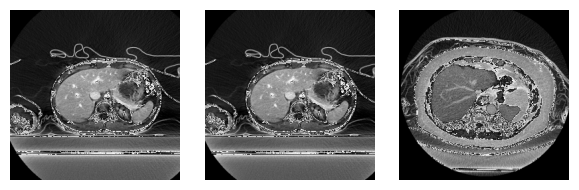

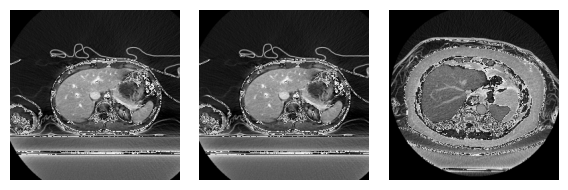

In [ ]:
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=3,
)

In [ ]:
def post_proc(pred):
    proc_pred = np.empty((pred.shape[0], 2*2 + 3*3), dtype="float32")

    # bowel, extravasation
    proc_pred[:, 0] = pred[:, 0]
    proc_pred[:, 1] = 1 - pred[:, 0]
    proc_pred[:, 2] = pred[:, 1]
    proc_pred[:, 3] = 1 - pred[:, 2]

    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Custom metric to calculate sensitivity
# @tf.function
# @tf.keras.utils.register_keras_serializable()
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(tf.round(y_pred), 1)), dtype=tf.float32))
    actual_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), dtype=tf.float32))
    return true_positives / (actual_positives + tf.keras.backend.epsilon())

# Custom metric to calculate specificity
# @tf.function
# @tf.keras.utils.register_keras_serializable()
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(tf.round(y_pred), 0)), dtype=tf.float32))
    actual_negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, 0), dtype=tf.float32))
    return true_negatives / (actual_negatives + tf.keras.backend.epsilon())

In [ ]:
patient_ids = meta_df["patient_id"].unique()
final_df = pd.DataFrame({'patient_id':patient_ids})

model_names = ["bowel", "extravasation", "kidney", "liver", "spleen"]
for i, name in enumerate(model_names):
  model_filename = f"EfficinetnetB3_{name}.keras"
  model_path = os.path.join(BASE_PATH, "checkpoint", model_filename)
  if name =="bowel" or name=="extravasation":
    model = tf.keras.models.load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sensitivity, specificity])
    # model = tf.keras.models.load_model(model_path, custom_objects={"sensitivity": sensitivity, "specificity": specificity})
  else:
    model = tf.keras.models.load_model(model_path)
  # Show the model architecture
  model.summary()
  print(f"Output shape for model {name}: {model.output_shape}")

  # Initializing array to store predictions
  output_dim = model.output_shape[-1]  # This should be 3 for the kidney model
  patient_preds = np.zeros(shape=(len(patient_ids), output_dim), dtype="float32")

  # Iterating over each patient
  for pidx, patient_id in tqdm(enumerate(patient_ids), total=len(patient_ids), desc="Patients "):
      print(f"Patient ID: {patient_id}")

      # Query the dataframe for a particular patient
      patient_df = meta_df[meta_df["patient_id"] == patient_id]

      # Getting image paths for a patient
      patient_paths = [path for path in patient_df.image_path.tolist() if os.path.exists(path)]

      # Building dataset for prediction
      dtest = build_dataset(patient_paths)

      pred = model.predict(dtest)

      # pred = pred.squeeze()  # Removes singleton dimensions, if any. This will convert shape from (1,1) to (1,) if required.
      print(f"Predictions shape for patient {patient_id}: {pred.shape}")

      # If the prediction shape is (1,), reshape it to (1, 1) for consistency.
      if len(pred.shape) == 1:
          pred = pred.reshape(1, 1)

      # Use the correct dimension based on the prediction shape.
      if len(pred.shape) == 2:
          dim = pred.shape[1]
      else:
          # Handle other shapes or raise an exception if unexpected
          raise ValueError(f"Unexpected shape for pred: {pred.shape}")

      pred = np.mean(pred.reshape(1, len(patient_paths), dim), axis=0)
      pred = np.max(pred, axis=0, keepdims=True)
      patient_preds[pidx, :output_dim] = pred.squeeze()


      # Deleting variables to free up memory
      del patient_df, patient_paths, dtest, pred; gc.collect()

  temp_df = pd.DataFrame(patient_preds, columns=[f"{name}_pred_{j}" for j in range(output_dim)])

  # Merge the temporary DataFrame with the final DataFrame on the patient IDs.
  final_df = pd.concat([final_df, temp_df], axis=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2_backbone       │ (16, 8, 8, 1536)          │ 12,930,622 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (16, 1536)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (16, 32)                  │     49,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bowel (Dense)                   │ (16, 1)                   │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 12,979,839 (49.51 MB)

 Trainable params: 12,870,623 (49.10 MB)

 Non-trainable params: 109,216 (426.62 KB)

Output shape for model bowel: (16, 1)


Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
Predictions shape for patient 48843: (2, 1)


Patients :  33%|███▎      | 1/3 [00:27<00:54, 27.19s/it]

Patient ID: 50046
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Predictions shape for patient 50046: (1, 1)


Patients :  67%|██████▋   | 2/3 [00:48<00:23, 23.52s/it]

Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


Patients : 100%|██████████| 3/3 [00:49<00:00, 13.44s/it]

Predictions shape for patient 63706: (1, 1)


Patients : 100%|██████████| 3/3 [00:49<00:00, 16.53s/it]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2_backbone       │ (16, 8, 8, 1536)          │ 12,930,622 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (16, 1536)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (16, 32)                  │     49,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ extravasation (Dense)           │ (16, 1)                   │         33 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 12,979,839 (49.51 MB)

 Trainable params: 12,870,623 (49.10 MB)

 Non-trainable params: 109,216 (426.62 KB)

Output shape for model extravasation: (16, 1)


Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predictions shape for patient 48843: (2, 1)


Patients :  33%|███▎      | 1/3 [00:11<00:23, 11.65s/it]

Patient ID: 50046
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


Patients :  67%|██████▋   | 2/3 [00:24<00:12, 12.24s/it]

Predictions shape for patient 50046: (1, 1)
Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Predictions shape for patient 63706: (1, 1)


Patients : 100%|██████████| 3/3 [00:25<00:00,  8.45s/it]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2_backbone       │ (16, 8, 8, 1536)          │ 12,930,622 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (16, 1536)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (16, 32)                  │     49,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ kidney (Dense)                  │ (16, 3)                   │         99 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,721,284 (147.71 MB)

 Trainable params: 12,870,689 (49.10 MB)

 Non-trainable params: 109,216 (426.62 KB)

 Optimizer params: 25,741,379 (98.20 MB)

Output shape for model kidney: (16, 3)


Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
Predictions shape for patient 48843: (2, 3)


Patients :  33%|███▎      | 1/3 [00:14<00:29, 14.85s/it]

Patient ID: 50046


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Predictions shape for patient 50046: (1, 3)


Patients :  67%|██████▋   | 2/3 [00:31<00:16, 16.06s/it]

Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predictions shape for patient 63706: (1, 3)


Patients : 100%|██████████| 3/3 [00:32<00:00, 10.96s/it]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (16, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2_backbone_1     │ (16, 8, 8, 1536)          │ 12,930,622 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (16, 1536)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (16, 32)                  │     49,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ liver (Dense)                   │ (16, 3)                   │         99 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,721,284 (147.71 MB)

 Trainable params: 12,870,689 (49.10 MB)

 Non-trainable params: 109,216 (426.62 KB)

 Optimizer params: 25,741,379 (98.20 MB)

Output shape for model liver: (16, 3)


Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predictions shape for patient 48843: (2, 3)


Patients :  33%|███▎      | 1/3 [00:12<00:24, 12.16s/it]

Patient ID: 50046
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


Patients :  67%|██████▋   | 2/3 [00:25<00:12, 12.79s/it]

Predictions shape for patient 50046: (1, 3)
Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions shape for patient 63706: (1, 3)


Patients : 100%|██████████| 3/3 [00:27<00:00,  9.07s/it]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (16, 256, 256, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ efficient_net_v2_backbone       │ (16, 8, 8, 1536)          │ 12,930,622 │
│ (EfficientNetV2Backbone)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (16, 1536)                │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (16, 32)                  │     49,184 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spleen (Dense)                  │ (16, 3)                   │         99 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 38,721,284 (147.71 MB)

 Trainable params: 12,870,689 (49.10 MB)

 Non-trainable params: 109,216 (426.62 KB)

 Optimizer params: 25,741,379 (98.20 MB)

Output shape for model spleen: (16, 3)


Patients :   0%|          | 0/3 [00:00<?, ?it/s]

Patient ID: 48843
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predictions shape for patient 48843: (2, 3)


Patients :  33%|███▎      | 1/3 [00:13<00:27, 13.76s/it]

Patient ID: 50046
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


Patients :  67%|██████▋   | 2/3 [00:27<00:13, 13.85s/it]

Predictions shape for patient 50046: (1, 3)
Patient ID: 63706
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predictions shape for patient 63706: (1, 3)


Patients : 100%|██████████| 3/3 [00:28<00:00,  9.66s/it]


In [ ]:
final_df['bowel_pred_1'] = 1 - final_df['bowel_pred_0']

# Reorder the columns to place 'bowel_pred_1' immediately after 'bowel_pred_0'.
columns_order = final_df.columns.tolist()
bowel_pred_0_index = columns_order.index('bowel_pred_0')
columns_order.insert(bowel_pred_0_index + 1, columns_order.pop(-1))  # Moving the last column to the desired position
final_df = final_df[columns_order]

final_df['extravasation_pred_1'] = 1 - final_df['extravasation_pred_0']

columns_order = final_df.columns.tolist()
extravasation_pred_0_index = columns_order.index('extravasation_pred_0')
columns_order.insert(extravasation_pred_0_index + 1, columns_order.pop(-1))  # Moving the last column to the desired position
final_df = final_df[columns_order]

final_df.columns = [['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high']]

In [ ]:
final_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.500169,0.499831,0.499982,0.500018,0.333936,0.332301,0.333763,0.333405,0.333461,0.333134,0.335727,0.338450,0.325824
1,50046,0.500182,0.499818,0.499868,0.500132,0.333988,0.332407,0.333606,0.333312,0.333591,0.333097,0.336192,0.342542,0.321266
2,63706,0.500311,0.499689,0.499898,0.500102,0.333942,0.332254,0.333804,0.333374,0.333392,0.333234,0.337117,0.341254,0.321629


In [ ]:
sub_df = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")
sub_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [ ]:
# Store submission
final_df.to_csv(BASE_PATH + "/test.csv ",index=False)